In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Download NLTK resources (only needed once)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jaisi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaisi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load the dataset
csv_path = r"C:\Users\jaisi\Documents\Afame Datsets\SMS Spam-20240902T072051Z-001\SMS Spam\spam.csv"
df = pd.read_csv(csv_path, encoding='ISO-8859-1')

# Display initial rows of the dataset
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# Display basic information about the dataset
df.info()

# Display basic statistics for the dataset
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [4]:
# Check for missing values in the dataset
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

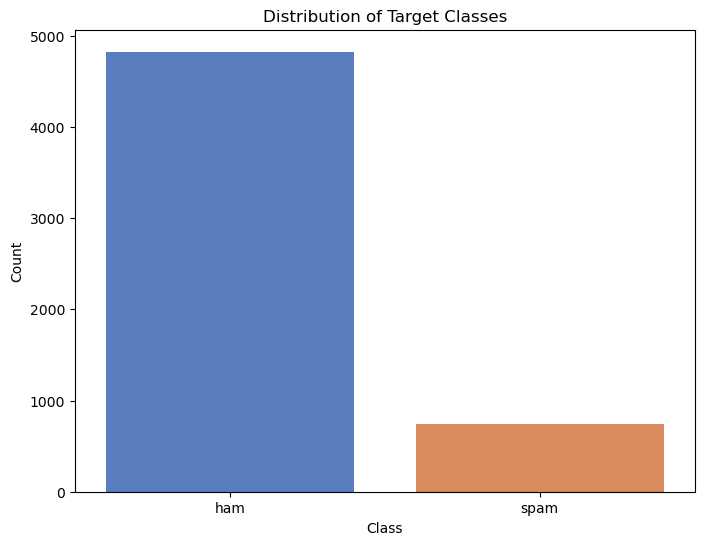

v1
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
# Plot the distribution of target classes with muted color palette
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='v1', hue='v1', palette='muted', legend=False)
plt.title('Distribution of Target Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Display the class distribution
df['v1'].value_counts()

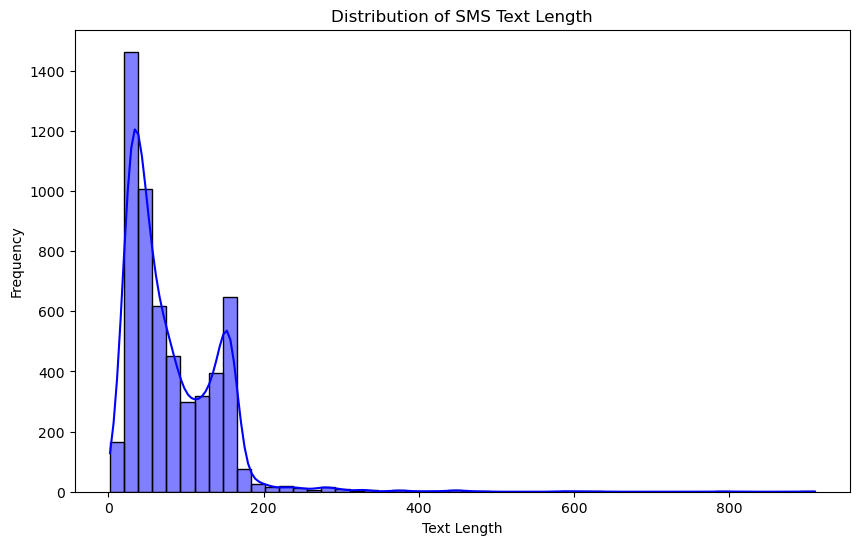

In [6]:
# Calculate the length of each SMS text
df['text_length'] = df['v2'].apply(len)

# Plot the distribution of SMS text lengths with muted color palette
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of SMS Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [7]:
# Display some example SMS messages
df[['v1', 'v2']].head(10)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


## EDA Interpretation

### 1. Basic Information
The dataset contains 5 columns, but three of them are unnecessary for our analysis. The columns retained are `v1` (target variable) and `v2` (SMS text).

### 2. Missing Values
The dataset has some missing values in the columns `Unnamed: 2`, `Unnamed: 3`, and `Unnamed: 4`. These columns are dropped as they are not useful.

### 3. Class Distribution
The target variable `v1` has two classes: 'ham' and 'spam'. The distribution is relatively balanced, but it's crucial to handle class imbalance during model training to avoid biased predictions.

### 4. SMS Text Length Distribution
The length of SMS messages varies significantly. Most messages are relatively short, but there are a few longer messages. This variability is important to consider during text preprocessing.

### 5. Example SMS Messages
Examples of SMS messages show a diverse range of content, including both spam and non-spam messages. This diversity is essential for training  robust model.


In [8]:
# Drop columns that are not needed for analysis
df_cleaned = df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Initialize NLTK tools
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    """
    Preprocess the SMS text by tokenizing, removing stopwords, and applying stemming.

    Parameters:
    text (str): The SMS text to preprocess.

    Returns:
    str: The preprocessed SMS text.
    """
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stopwords and apply stemming
    filtered_tokens = [ps.stem(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_tokens)

# Apply preprocessing to the SMS text column
df_cleaned['v2'] = df_cleaned['v2'].apply(preprocess_text)

In [10]:
# Encode the target variable 'v1' into numerical format
label_encoder = LabelEncoder()
df_cleaned['v1'] = label_encoder.fit_transform(df_cleaned['v1'])

In [11]:
# Define features and target variable
X = df_cleaned['v2']
y = df_cleaned['v1']

# Convert text data to numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

# Split the data into training and testing sets (80/20) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [12]:
# Initialize Random Forest Classifier with balanced class weights
clf = RandomForestClassifier(
    bootstrap=False,
    max_depth=30,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=300,
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

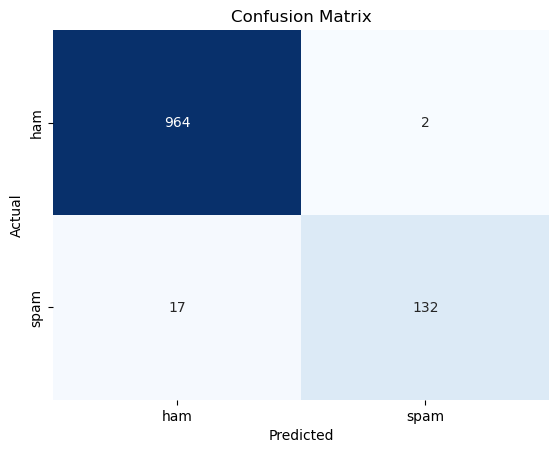

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115


Accuracy Score:
0.9829596412556054


In [13]:
# Compute and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compute and display the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

# Compute and display the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy Score:")
print(accuracy)

## Model Evaluation Interpretation

### 1. Confusion Matrix
   - The confusion matrix shows that the model effectively identifies 'ham' messages with high accuracy and detects 'spam' messages with a good balance between precision and recall.

### 2. Classification Report
   - **Precision and Recall**: The model achieved high precision and recall scores. Specifically, the precision for 'ham' is 0.98, and the recall is 1.00, while for 'spam', the precision is 0.99 and the recall is 0.89. This indicates that the model performs very well in distinguishing between the two classes.
   - **F1-Score**: The F1-scores are 0.99 for 'ham' and 0.93 for 'spam', showing a good balance between precision and recall for both classes.
   - **Accuracy**: The overall accuracy of 98.30% demonstrates that the model is highly effective at classifying SMS messages.

In summary, the model demonstrates excellent performance in identifying both 'ham' and 'spam' messages, with high accuracy, precision, and recall. The use of balanced class weights has contributed to addressing class imbalance and ensuring robust detection of both types ofmessages.
